### Calculate condition specificity, annotate cluster size

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time


sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [89]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad', backed='r')

In [90]:
adata_final

AnnData object with n_obs × n_vars = 2336 × 13959 backed at '../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering.h5ad'
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan', 'hdbscan_cluster_size', 'hdbscan_cluster_gene_size', 'hdbscan_corr_rest_over_corr_all', 'hdbscan_corr_stim8hr_over_corr_all', 'hdbscan_corr_stim48hr_over_corr_all'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [91]:
adata_final.obs['hdbscan_corr_rest_over_across_condition'] = 0
adata_final.obs['hdbscan_corr_stim8hr_over_across_condition'] = 0
adata_final.obs['hdbscan_corr_stim48hr_over_across_condition'] = 0

In [ ]:
for cl in adata_final.obs['hdbscan'].unique():

    gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
    corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['zscore'].T,
                           columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
    corr_all = corr_all.reset_index()
    corr_all = corr_all.rename(columns={'index': 'Index_ID'})
    corr_all_long = pd.melt(corr_all, 
                            id_vars=['Index_ID'],
                            var_name='Column_ID',
                            value_name='Correlation_Value'
                           )
    corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
    corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
    corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

    corr_across_condition_mean = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.mean()
    
    corr_rest_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.mean()
    corr_stim8hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.mean()
    corr_stim48hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.mean()

    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_rest_over_across_condition'] = corr_rest_mean/corr_across_condition_mean
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim8hr_over_across_condition'] = corr_stim8hr_mean/corr_across_condition_mean
    adata_final.obs.loc[adata_final.obs['hdbscan']==cl, 'hdbscan_corr_stim48hr_over_across_condition'] = corr_stim48hr_mean/corr_across_condition_mean

In [110]:
condition_specificity = adata_final.obs[['hdbscan', 'hdbscan_cluster_gene_size', 'hdbscan_corr_rest_over_across_condition',
                                         'hdbscan_corr_stim8hr_over_across_condition', 'hdbscan_corr_stim48hr_over_across_condition']].drop_duplicates().sort_values(by='hdbscan').set_index('hdbscan', drop=True)

In [112]:
condition_specificity = condition_specificity[condition_specificity.hdbscan_cluster_gene_size>=4]

In [120]:
hdbscan_order = np.array([0, 1, 2, 6, 7, 
                          14, 13, 25, 84, 
                          15, 
                          36, 60, 67, 
                          40, 53, 
                          43, 
                          97, 108,
                          39, 45, 55, 68, 78, 86, 92, # unknown, not specific
                          56,
                          73, 87, 94, 58, # cell cycle upstream
                          65, # unknown, stim8hr
                          61, 66, 74, 88, # unknown, rest & stim8hr
                          72, 90, 96, # unknown, rest
                          54, # stim48hr
                          98, # stim48hr
                          69, # stim48hr
                          107,
                          37, 109, 
                          77, 83, 102, 104]) # unknown, stim48hr

In [121]:
set(condition_specificity.index) - set(hdbscan_order)

{4, 9, 18, 38, 44, 52, 57, 63, 75, 79, 81, 101, 106}

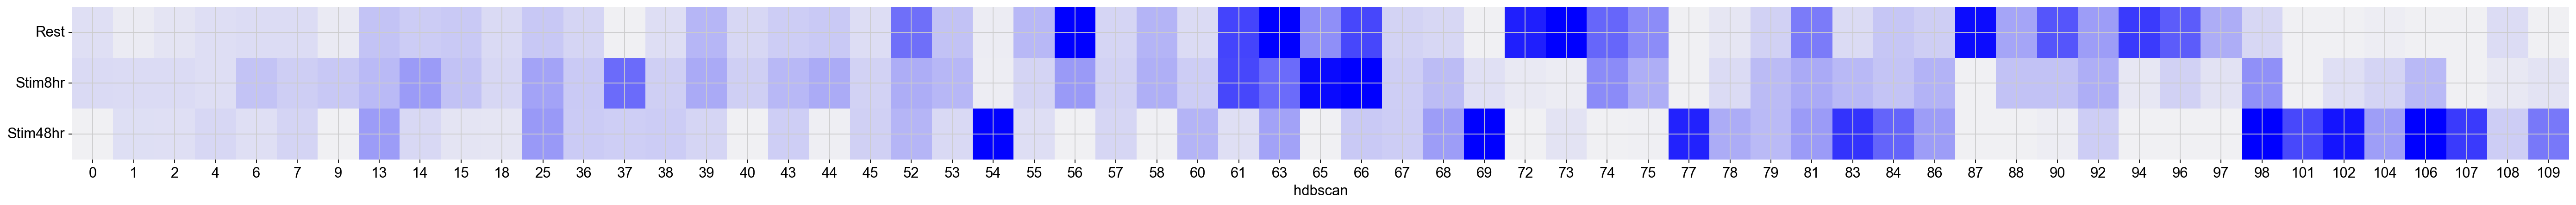

In [172]:
fig, ax = plt.subplots(figsize=(35, 3))
sns.heatmap(condition_specificity.iloc[:,1:].T, vmin=1, vmax=6, ax=ax, cmap=sns.color_palette("light:b", as_cmap=True), cbar=False)
ax.set_yticklabels(['Rest', 'Stim8hr', 'Stim48hr'], rotation=0)
plt.tight_layout()

In [ ]:
condition_specificity

In [101]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

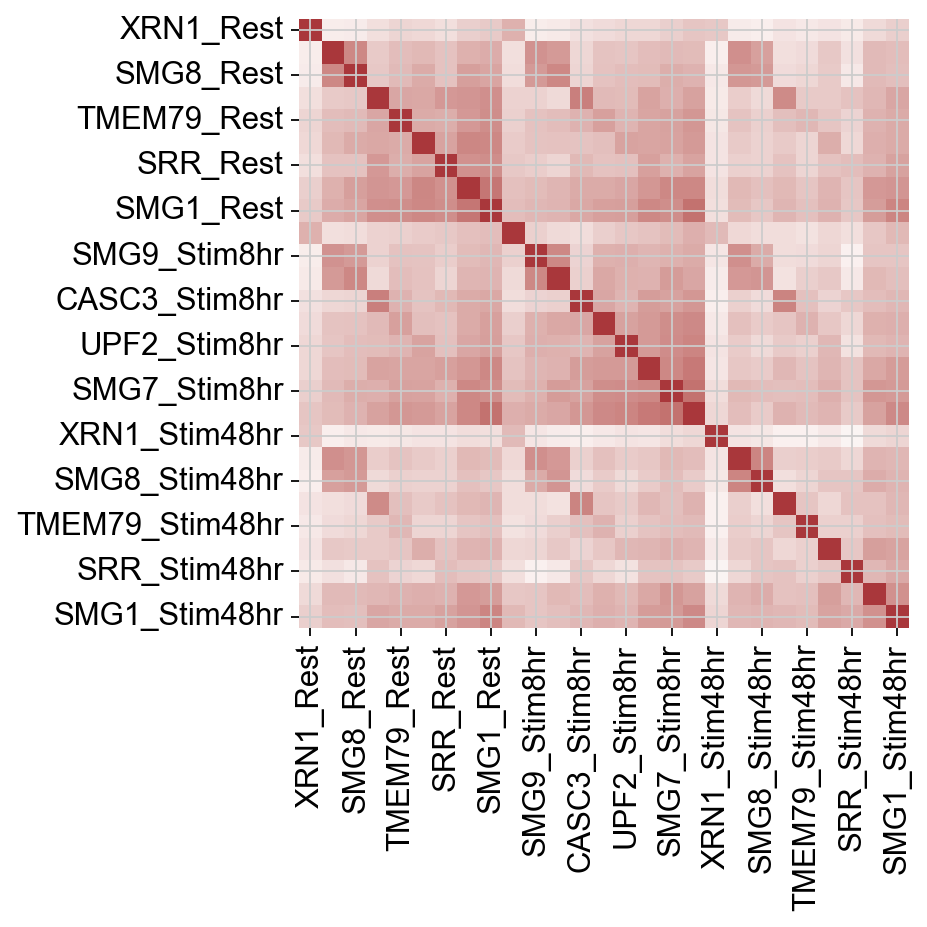

In [173]:
cl = 0
thres = 1
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].unique().tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', cbar=False)#, xticklabels=False, yticklabels=False)
#plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
#plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
#plt.savefig('./results/cluster'+str(cl)+'.png')

In [180]:
cl = 0
gene_id_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
corr_all = pd.DataFrame(adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].layers['zscore'].T,
                       columns=adata_de[adata_de.obs['target_contrast_corrected'].isin(gene_id_list)].obs_names).corr()
corr_all = corr_all.reset_index()
corr_all = corr_all.rename(columns={'index': 'Index_ID'})
corr_all_long = pd.melt(corr_all, 
                        id_vars=['Index_ID'],
                        var_name='Column_ID',
                        value_name='Correlation_Value'
                       )
corr_all_long[['perturbation_1', 'perturbation_1_condition']] = corr_all_long['Index_ID'].str.split('_',n=1,expand=True)
corr_all_long[['perturbation_2', 'perturbation_2_condition']] = corr_all_long['Column_ID'].str.split('_',n=1,expand=True)
corr_all_long = corr_all_long[corr_all_long['perturbation_1']!=corr_all_long['perturbation_2']]

corr_across_condition_mean = corr_all_long[corr_all_long.perturbation_1_condition!=corr_all_long.perturbation_2_condition].Correlation_Value.mean()

corr_rest_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Rest')&(corr_all_long.perturbation_2_condition=='Rest')].Correlation_Value.mean()
corr_stim8hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim8hr')&(corr_all_long.perturbation_2_condition=='Stim8hr')].Correlation_Value.mean()
corr_stim48hr_mean = corr_all_long[(corr_all_long.perturbation_1_condition=='Stim48hr')&(corr_all_long.perturbation_2_condition=='Stim48hr')].Correlation_Value.mean()

In [181]:
corr_across_condition_mean

0.27617561369139526

In [182]:
corr_rest_mean, corr_stim8hr_mean, corr_stim48hr_mean

(0.3772636894623014, 0.41080414908189233, 0.26279878782443)

In [183]:
regulator_main_condition

['CASC3_Stim8hr',
 'SMG7_Stim8hr',
 'SMG9_Stim8hr',
 'SRR_Stim8hr',
 'XRN1_Stim8hr',
 'UPF2_Stim8hr',
 'SMG1_Stim8hr',
 'SMG8_Stim8hr',
 'TMEM79_Stim8hr']

In [127]:
regulator_reordered

array(['PIM1', 'GATAD1', 'GATAD1', 'PHF12', 'PHF12', 'PHF12', 'SIN3B',
       'SIN3B', 'SIN3B'], dtype='<U6')

In [126]:
regulator_rest

['PIM1_Rest',
 'GATAD1_Rest',
 'GATAD1_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'PHF12_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest',
 'SIN3B_Rest']

In [125]:
regulator_all

array(['PIM1_Rest', 'GATAD1_Rest', 'GATAD1_Rest', 'PHF12_Rest',
       'PHF12_Rest', 'PHF12_Rest', 'SIN3B_Rest', 'SIN3B_Rest',
       'SIN3B_Rest', 'PIM1_Stim8hr', 'GATAD1_Stim8hr', 'GATAD1_Stim8hr',
       'PHF12_Stim8hr', 'PHF12_Stim8hr', 'PHF12_Stim8hr', 'SIN3B_Stim8hr',
       'SIN3B_Stim8hr', 'SIN3B_Stim8hr', 'GATAD1_Stim48hr',
       'GATAD1_Stim48hr', 'PHF12_Stim48hr', 'PHF12_Stim48hr',
       'PHF12_Stim48hr', 'SIN3B_Stim48hr', 'SIN3B_Stim48hr',
       'SIN3B_Stim48hr'], dtype='<U15')

In [124]:
corr_mtx

,GATAD1_Rest,PHF12_Rest,PIM1_Rest,SIN3B_Rest,GATAD1_Stim8hr,PHF12_Stim8hr,PIM1_Stim8hr,SIN3B_Stim8hr,GATAD1_Stim48hr,PHF12_Stim48hr,SIN3B_Stim48hr
GATAD1_Rest,1.000000,0.261294,0.353681,0.459397,0.217486,0.228700,0.126759,0.314830,0.257321,0.269159,0.389063
PHF12_Rest,0.261294,1.000000,0.349827,0.504099,0.251890,0.337057,0.263746,0.394425,0.215424,0.336632,0.361644
PIM1_Rest,0.353681,0.349827,1.000000,0.468329,0.186534,0.240274,0.337182,0.297659,0.196700,0.243432,0.340756
SIN3B_Rest,0.459397,0.504099,0.468329,1.000000,0.345852,0.368852,0.330362,0.596259,0.334250,0.411513,0.606398
GATAD1_Stim8hr,0.217486,0.251890,0.186534,0.345852,1.000000,0.377575,0.311144,0.470233,0.215212,0.238878,0.321314
PHF12_Stim8hr,0.228700,0.337057,0.240274,0.368852,0.377575,1.000000,0.363334,0.511770,0.207884,0.322089,0.358357
PIM1_Stim8hr,0.126759,0.263746,0.337182,0.330362,0.311144,0.363334,1.000000,0.392735,0.129980,0.207301,0.277003
SIN3B_Stim8hr,0.314830,0.394425,0.297659,0.596259,0.470233,0.511770,0.392735,1.000000,0.347026,0.406505,0.592103
GATAD1_Stim48hr,0.257321,0.215424,0.196700,0.334250,0.215212,0.207884,0.129980,0.347026,1.000000,0.339429,0.472985
PHF12_Stim48hr,0.269159,0.336632,0.243432,0.411513,0.238878,0.322089,0.207301,0.406505,0.339429,1.000000,0.515864
